In [1]:
import numpy as np
import pandas as pd
pd.set_option("future.no_silent_downcasting", True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv',index_col='PassengerId')
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col='PassengerId')
train_data.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


### Preprocess Data

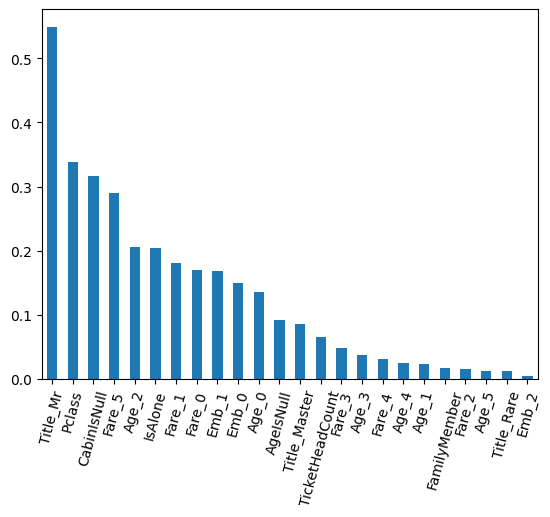

In [3]:
def preprocess_data(combined_data):
    social_status_mapping = {'Capt': 'Rare', 'Col': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Dr': 'Rare', 'Jonkheer': 'Rare', 'Lady': 'Rare', 'Major': 'Rare', 'Mlle': 'Miss', 'Mme': 'Miss', 'Mrs':'Miss', 'Ms': 'Miss', 'Rev': 'Rare', 'Sir': 'Rare', 'the Countess': 'Rare'}
    
    # full data
    total_data = pd.concat(combined_data)
    head_count = pd.Series(total_data.groupby('Ticket')['Name'].count()).to_dict()

    total_data['Title'] = total_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    age = total_data.groupby(['Title', 'Pclass'])['Age'].transform('median').fillna(total_data['Age'].median())
    combined_age = [age.iloc[:len(combined_data[0])], age.iloc[len(combined_data[0]):]]

    for data, age in zip(combined_data, combined_age):
        # imputing missing values
        data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
        data['AgeIsNull'] = np.where(data['Age'].isnull(), 1, 0)
        data['Age'] = np.where(data.Age.isnull(), age, data.Age)
        data['Fare'] = data['Fare'].fillna(data.Fare.median())
        data['CabinIsNull'] = np.where(data['Cabin'].isnull(), 1, 0)
        data['Cabin'] = data['Cabin'].fillna('NA')
        data['Embarked'] = data['Embarked'].fillna('S')
        data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

        # formating categorical features
        data['Title'] = data['Title'].replace(social_status_mapping)
        data['Sex'] = data['Sex'].replace({'female':0, 'male':1})
        data['TicketHeadCount'] = data['Ticket'].replace(head_count)

        # formating Numerical features
        data['AgeBin'] = pd.qcut(data['Age'], q=6, duplicates='drop', labels=False)
        data['FareBin'] = pd.qcut(data['Fare'], q=6, duplicates='drop', labels=False)
        data['IsAlone'] = np.where((data.Parch==0) & (data.SibSp==0), 1, 0)
        data['FamilyMember'] = data['SibSp'] + data['Parch'] + 1

def show_corr_plot(data, drop_features=[]):
    survived = data.Survived
    corr = train_data.drop(['Survived'] + drop_features, axis=1).corrwith(survived)
    corr = abs(corr)
    corr.sort_values(ascending=False,inplace=True)
    ax = corr.plot.bar(rot = 75)
    plt.show()

combined_data = [train_data, test_data]
preprocess_data(combined_data)

# performing one hot encoding
train_data = pd.get_dummies(train_data,columns=["Title","Embarked",'AgeBin','FareBin'], prefix=["Title","Emb",'Age','Fare'])
test_data = pd.get_dummies(test_data,columns=["Title","Embarked",'AgeBin','FareBin'], prefix=["Title","Emb",'Age','Fare'])

# dropping unnecessary features
drop = ['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Title_Miss', 'Sex', 'Parch', 'SibSp']
train_data = train_data.drop(drop, axis=1)
test_data = test_data.drop(drop, axis=1)

# show corr plot
show_corr_plot(train_data)

### Selecting Features with RFR, SelectKBest and Optuna

In [4]:
x_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
x_train_columns = x_train.columns;

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.17, random_state = 42)

scaler  = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val   = scaler.fit_transform(x_val)
x_test  = scaler.fit_transform(test_data)

def get_selector(type, n_features):
    return RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=n_features, step=1) if(type == 0) else \
        SelectKBest(f_classif, k=n_features)

def selector_accuracy_score(sel):
    x_train_sel = sel.fit_transform(x_train, y_train)
    x_val_sel = sel.transform(x_val)
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train_sel, y_train)
    y_val_pred = model.predict(x_val_sel)
    return accuracy_score(y_val, y_val_pred)

def objective(trial:optuna.Trial):
    n_features = trial.suggest_int("n_features", 3, 13)
    selector_type =  trial.suggest_int("selector_type", 0, 1)
    sel = get_selector(selector_type, n_features)
    return selector_accuracy_score(sel)

def get_best_selector():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    print('Number of finished trials: ', len(study.trials))
    print('Best trial parameters:', study.best_trial.params)
    print('Best score:', study.best_value)
    return get_selector(study.best_trial.params['selector_type'], study.best_trial.params['n_features'])

def get_selected_features(sel, feats):
    mask = sel.get_support()
    selected = []
    for v, feat in zip(mask, feats):
        if v:
            selected.append(feat)
    return selected

sel = get_best_selector()

[I 2024-10-26 18:52:34,750] A new study created in memory with name: no-name-69b007c1-19b0-4ef0-b906-88329849c093
[I 2024-10-26 18:52:34,978] Trial 0 finished with value: 0.8092105263157895 and parameters: {'n_features': 13, 'selector_type': 1}. Best is trial 0 with value: 0.8092105263157895.
[I 2024-10-26 18:52:39,757] Trial 1 finished with value: 0.8157894736842105 and parameters: {'n_features': 3, 'selector_type': 0}. Best is trial 1 with value: 0.8157894736842105.
[I 2024-10-26 18:52:39,981] Trial 2 finished with value: 0.8092105263157895 and parameters: {'n_features': 13, 'selector_type': 1}. Best is trial 1 with value: 0.8157894736842105.
[I 2024-10-26 18:52:44,438] Trial 3 finished with value: 0.8026315789473685 and parameters: {'n_features': 5, 'selector_type': 0}. Best is trial 1 with value: 0.8157894736842105.
[I 2024-10-26 18:52:48,631] Trial 4 finished with value: 0.8092105263157895 and parameters: {'n_features': 6, 'selector_type': 0}. Best is trial 1 with value: 0.8157894

Number of finished trials:  20
Best trial parameters: {'n_features': 11, 'selector_type': 0}
Best score: 0.8421052631578947


### Training and Prediction

In [5]:
x_train_sel = sel.fit_transform(x_train, y_train)
x_val_sel = sel.transform(x_val)
x_test_sel = sel.transform(x_test)
print("Selected Features:\n", get_selected_features(sel, x_train_columns))

model = RandomForestClassifier(random_state=42)
model.fit(x_train_sel, y_train)
y_val_pred = model.predict(x_val_sel)
print("Final Model Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n",confusion_matrix(y_val, y_val_pred))

# if needed, save predictions to a CSV file
y_test_pred = model.predict(x_test_sel)
output = pd.DataFrame({'PassengerId': pd.read_csv("/kaggle/input/titanic/test.csv")["PassengerId"], 'Survived': y_test_pred})
output.to_csv("/kaggle/working/submission.csv", index=False)

Selected Features:
 ['Pclass', 'AgeIsNull', 'CabinIsNull', 'TicketHeadCount', 'FamilyMember', 'Title_Mr', 'Title_Rare', 'Emb_0', 'Age_2', 'Age_3', 'Fare_5']
Final Model Accuracy: 0.8421052631578947
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87        91
           1       0.84      0.75      0.79        61

    accuracy                           0.84       152
   macro avg       0.84      0.83      0.83       152
weighted avg       0.84      0.84      0.84       152

Confusion Matrix:
 [[82  9]
 [15 46]]
